# Starbucks Rewards: Predicting Consumer Responses

## Project Overview

This project seeks to determines how do we take data and discover what are the offers that excite people? We want to know what is the most valuable offer there is, not just for the customers as a whole but at an individual personal level.

Link to an academic paper where machine learning was applied to this type of problem: http://ceur-ws.org/Vol-3026/paper18.pdf

## Problem Statement

Predict if someone will reply to an offer. Transaction data and demographic information must be combined and gitHub
customers will also have access to the data. We will analyze the attributes of customers to create customer classifications. This is a multi-class classification problem so the key metric we will use is f1-score. The simulating dataset only has one product, while Starbucks offers dozens of products. Therefore, this data set is a simplified version of the real Starbucks app.

In [2]:
from collections import defaultdict
import pandas as pd
import sagemaker
from sklearn.model_selection import train_test_split
from sagemaker.xgboost.estimator import XGBoost
from sklearn import preprocessing
import matplotlib.pyplot as plt

## Data Exploration

### Dataset details

portfolio.json
* id (string) - offer id
* offer_type (string) - a type of offer ie BOGO, discount, informational
* difficulty (int) - the minimum required to spend to complete an offer
* reward (int) - the reward is given for completing an offer
* duration (int) - time for the offer to be open, in days
* channels (list of strings)

profile.json
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

transcript.json
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since the start of the test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [3]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Index(['gender', 'age', 'id', 'became_member_on', 'income'], dtype='object')


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'became_member_on'}>],
       [<AxesSubplot:title={'center':'income'}>, <AxesSubplot:>]],
      dtype=object)

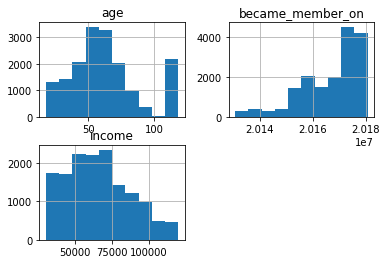

In [4]:
print(profile.columns)
profile.hist()

In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [9]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


There are 17000 records where the average age is 63 years old and the average income is $65000 and there are 2175 missing data points from income and gender. We will need to consider what we do with these values later one. We can safely ignore the id as these don't mean anything. As for became_member_on we can confirm that most customers became a member in 2017 and 2018.

<AxesSubplot:>

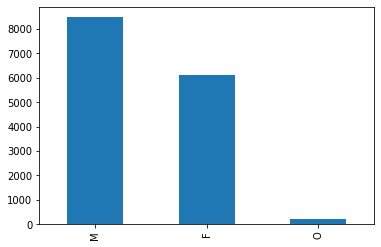

In [5]:
profile['gender'].value_counts().plot(kind='bar')

In [6]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [7]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


<AxesSubplot:>

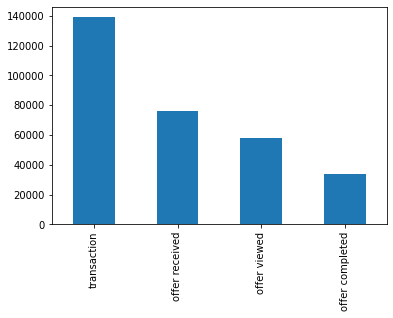

In [8]:
transcript['event'].value_counts().plot(kind='bar')

## Data Preprocessing

We will handle missing values in the <strong>genders</strong> column in the `profile.json` data set by deleting rows

Pros:
Complete removal of data with missing values results in robust and highly accurate model
Deleting a particular row or a column with no specific information is better, since it does not have a high weightage

Cons:
Loss of information and data
Works poorly if the percentage of missing values is high (say 30%), compared to the whole dataset

In [ ]:
profile.dropna(inplace=True)
profile.head()

### Note: We only consider customers who received offers.

In [ ]:
new_transcript = transcript[transcript['event'].str.startswith('o')]
new_transcript.head()

In [ ]:
# Split / Explode a column of dictionaries into separate columns 
new_transcript = pd.concat([new_transcript.drop(['value'], axis=1), new_transcript['value'].apply(pd.Series)], axis=1)
new_transcript.head()

In [ ]:
new_transcript = new_transcript.dropna(subset = ["offer_id"])

temp1 = portfolio.rename(columns={"id": "offer_id"})
temp2 = profile.rename(columns={"person": "id"})

data = pd.merge(new_transcript, temp1, on="offer_id").rename(columns={"person": "id"})
data = pd.merge(data, temp2, on="id")

In [ ]:
# Creating additional features
data['became_member_on'] = pd.to_datetime(data['became_member_on'],format='%Y%m%d')

data["year"] = data.became_member_on.dt.year
data["month"] = data.became_member_on.dt.month
data["day"] = data.became_member_on.dt.day

data.head()

In [ ]:
to_drop = ['offer id',
           'event',
           'id',
           'became_member_on',
           'reward_y',
           'reward_x',
           'time',
           'offer_type']
           
data.drop(to_drop, inplace=True, axis=1)
print(data)

We will handle missing values in the <strong>income</strong> column in `data` by deleting rows. 

In [ ]:
data.dropna(inplace=True)
data.info()

#### Notice we only have 8 offers from previous 10 in the `portfolio.json` file. This is because two are merely informational

In [ ]:
target_vals = {offer_id for offer_id in data['offer_id']}
print(target_vals)

## Set target to be offer_id

In [ ]:
data['target'] = data['offer_id']
data.drop('offer_id', inplace=True, axis=1)
data.head()

In [ ]:
# Convert object type to avoid error

lbl = preprocessing.LabelEncoder()
data['gender'] = lbl.fit_transform(data['gender'].astype(str))
data['target'] = lbl.fit_transform(data['target'].astype(str))
data['channels'] = lbl.fit_transform(data['gender'].astype(str))
data.info()

In [ ]:
data = data.drop_duplicates()

## Class distributions of offers completed (Exploratory Visualization)

In [ ]:
offer_count = defaultdict(int)
for offer in data['target']:
    if offer in offer_count:
        offer_count[offer]+=1
    else:
        offer_count[offer] = 1

class_count = pd.DataFrame.from_dict(offer_count, orient='index')
bar_plot = class_count.plot.bar(title="Number of occurrences")

In [ ]:
data.to_csv('data.csv', index = False)

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=0)

In [ ]:
train.to_csv('data/train/train.csv', index = False)
test.to_csv('data/test/test.csv', index = False)

## Upload to S3 bucket

In [ ]:
sagemaker_session = sagemaker.Session()

bucket = "my-project-bucket-123"
region ="us-east-1" 
role = "arn:aws:iam::657240468511:role/service-role/AmazonSageMaker-ExecutionRole-20211225T133929"

print("Default Bucket: {}".format(bucket))
print("AWS Region: {}".format(region))
print("RoleArn: {}".format(role))

In [ ]:
s3_path_to_data = sagemaker.Session().upload_data(bucket=bucket, 
                                                  path='data/train', 
                                                  key_prefix='train')

s3_path_to_data = sagemaker.Session().upload_data(bucket=bucket, 
                                                  path='data/test', 
                                                  key_prefix='test')


## Benchmark

We will be using multiclass logistic regression against which we can benchmark.

In [ ]:
benchmark_data = pd.read_csv ('data.csv')
benchmark_train, benchmark_test = train_test_split(data, test_size=0.2, random_state=0)

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10000 )
X = benchmark_train.iloc[:, :-1]
y = benchmark_train.iloc[:, -1:]
model.fit(X, y.values.ravel())


In [ ]:
from sklearn.metrics import f1_score

preds = model.predict(benchmark_test.iloc[:,:-1])
score=f1_score(benchmark_test["target"], preds, average='weighted')
print(f"f1-score: {score}")

## Model Training
**Note:** You will need to use the `train.py` script to train your model.

In [ ]:
output_path = 's3://{}/output'.format(bucket)
input_data = 's3://{}/'.format(bucket)

metric_definitions = [{'Name': 'validation:f1', 'Regex': '.*\[[0-9]+\].*#011validation-f1:([-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'}]

xgb_estimator = XGBoost(
    entry_point="train.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version="1.3-1",
    output_path=output_path,

)

In [ ]:
train_input = input_data + "train"
test_input = input_data + "test"

In [ ]:
xgb_estimator.fit({'train': train_input, 'validation': test_input})

## Standout suggestions

### Hyperparameter Tuning

In [ ]:

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "max_depth": IntegerParameter(2, 8),
    "eta": ContinuousParameter(0.1, 0.5),
    "num_round" : CategoricalParameter([10, 50, 100]),
}

objective_metric_name = "validation:f1"


In [ ]:
xgb_estimator = XGBoost(
    entry_point="train.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version="1.3-1",
    output_path=output_path,

)

tuner = HyperparameterTuner(
    xgb_estimator,
    objective_metric_name,
    hyperparameter_ranges, 
    max_jobs=2, 
    max_parallel_jobs=4 
)

In [ ]:
tuner.fit({'train': train_input, "validation": test_input})

The final results compared to the benchmark result is higher by a large margin. 
Therefore the final model and solution is significant enough to have adequately solved the problem.

In [ ]:
tuner.describe()['BestTrainingJob']['FinalHyperParameterTuningJobObjectiveMetric']

In [ ]:
best_estimator = tuner.describe()['BestTrainingJob']['TunedHyperParameters']
print(best_estimator)

In [ ]:
max_depth = int(best_estimator["max_depth"])
eta = float(best_estimator['eta'])
num_round = int(best_estimator['num_round'][1:-1])

print("max_depth: {}".format(max_depth))
print("eta: {}".format(eta))
print("num_round: {}".format(num_round))

In [ ]:
hyperparameters = {
    "max_depth": max_depth,
    "eta": eta,
    "num_round": num_round
}

In [ ]:
output_path = 's3://{}/output'.format(bucket)
input_data = 's3://{}/'.format(bucket)

xgb_estimator = XGBoost(
    entry_point="train.py",
    hyperparameters=hyperparameters,
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version="1.3-1",
    output_path=output_path,

)

In [ ]:
xgb_estimator.fit({'train': train_input, "validation": test_input})

In [ ]:
pt_model_data = xgb_estimator.model_data
print("Model artifact saved at:\n", pt_model_data)

### Model Deploying and Querying

In [ ]:
from time import gmtime, strftime

timestamp_prefix = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
endpoint_name = "inference-pipeline-ep-" + timestamp_prefix

In [ ]:
predictor=xgb_estimator.deploy(instance_type="ml.m5.large", initial_instance_count=1, endpoint_name=endpoint_name) 

In [ ]:
from sagemaker.predictor import Predictor

payload = '0,10,7,0,69,70000.0,2018,5,14'

predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer=sagemaker.serializers.CSVSerializer(),
    content_type="text/csv",
    accept="application/json")

print(predictor.predict(payload))

In [ ]:
predictor.delete_endpoint()